In [67]:
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg
from pyspark.sql.types import FloatType

from sklearn import metrics

from math import sqrt
from math import pi
from math import exp

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns

In [3]:
spark = SparkSession.builder.master("local").appName("Colab").getOrCreate()

In [24]:
df = spark.read.option("header", True)\
                    .csv("healthcare-dataset-stroke-data.csv")

df.printSchema()
                 

root
 |-- id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: string (nullable = true)
 |-- hypertension: string (nullable = true)
 |-- heart_disease: string (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: string (nullable = true)
 |-- bmi: string (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: string (nullable = true)



In [20]:
df.count()

5110

In [21]:
df.take(5)

[Row(id='9046', gender='Male', age='67', hypertension='0', heart_disease='1', ever_married='Yes', work_type='Private', Residence_type='Urban', avg_glucose_level='228.69', bmi='36.6', smoking_status='formerly smoked', stroke='1'),
 Row(id='51676', gender='Female', age='61', hypertension='0', heart_disease='0', ever_married='Yes', work_type='Self-employed', Residence_type='Rural', avg_glucose_level='202.21', bmi='N/A', smoking_status='never smoked', stroke='1'),
 Row(id='31112', gender='Male', age='80', hypertension='0', heart_disease='1', ever_married='Yes', work_type='Private', Residence_type='Rural', avg_glucose_level='105.92', bmi='32.5', smoking_status='never smoked', stroke='1'),
 Row(id='60182', gender='Female', age='49', hypertension='0', heart_disease='0', ever_married='Yes', work_type='Private', Residence_type='Urban', avg_glucose_level='171.23', bmi='34.4', smoking_status='smokes', stroke='1'),
 Row(id='1665', gender='Female', age='79', hypertension='1', heart_disease='0', eve

In [25]:
numeric_columns = ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']
for column in numeric_columns:
  df = df.withColumn(column, df[column].cast(FloatType()))
df.printSchema()

root
 |-- id: float (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: float (nullable = true)
 |-- hypertension: float (nullable = true)
 |-- heart_disease: float (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: float (nullable = true)
 |-- bmi: float (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: float (nullable = true)



In [14]:
df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
id,5110,36517.82935420744,21161.72162482715,67.0,72940.0
gender,5110,None,None,Female,Other
age,5110,43.22661448143525,22.61264672306245,0.08,82.0
hypertension,5110,0.0974559686888454,0.296606674233791,0.0,1.0
heart_disease,5110,0.05401174168297456,0.22606298750336554,0.0,1.0
ever_married,5110,None,None,No,Yes
work_type,5110,None,None,Govt_job,children
Residence_type,5110,None,None,Rural,Urban
avg_glucose_level,5110,106.14767708078523,45.2835601574783,55.12,271.74


In [26]:
df = df.toPandas()

In [27]:
df['bmi'].fillna(value=df['bmi'].mean(), inplace=True)
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046.0,Male,67.0,0.0,1.0,Yes,Private,Urban,228.690002,36.599998,formerly smoked,1.0
1,51676.0,Female,61.0,0.0,0.0,Yes,Self-employed,Rural,202.210007,28.893234,never smoked,1.0
2,31112.0,Male,80.0,0.0,1.0,Yes,Private,Rural,105.919998,32.500000,never smoked,1.0
3,60182.0,Female,49.0,0.0,0.0,Yes,Private,Urban,171.229996,34.400002,smokes,1.0
4,1665.0,Female,79.0,1.0,0.0,Yes,Self-employed,Rural,174.119995,24.000000,never smoked,1.0


In [29]:
data = df.drop(columns=['id', 'ever_married','Residence_type'], axis=1)

In [30]:
data = data.replace(to_replace = 'Male', value = 1)
data = data.replace(to_replace = 'Female', value = 0)
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,Private,228.690002,36.599998,formerly smoked,1.0
1,0,61.0,0.0,0.0,Self-employed,202.210007,28.893234,never smoked,1.0
2,1,80.0,0.0,1.0,Private,105.919998,32.500000,never smoked,1.0
3,0,49.0,0.0,0.0,Private,171.229996,34.400002,smokes,1.0
4,0,79.0,1.0,0.0,Self-employed,174.119995,24.000000,never smoked,1.0


In [31]:
data.gender.value_counts()

0        2994
1        2115
Other       1
Name: gender, dtype: int64

In [32]:
data = data.replace(to_replace = 'Other',value = 1)
data.gender.value_counts()

0    2994
1    2116
Name: gender, dtype: int64

In [33]:
data["work_type"] = data["work_type"].astype("category")
data["work_type"] = data["work_type"].cat.codes
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,2,228.690002,36.599998,formerly smoked,1.0
1,0,61.0,0.0,0.0,3,202.210007,28.893234,never smoked,1.0
2,1,80.0,0.0,1.0,2,105.919998,32.500000,never smoked,1.0
3,0,49.0,0.0,0.0,2,171.229996,34.400002,smokes,1.0
4,0,79.0,1.0,0.0,3,174.119995,24.000000,never smoked,1.0


In [35]:
data["smoking_status"] = data["smoking_status"].astype("category")
data["smoking_status"] = data["smoking_status"].cat.codes
data.head()

,gender,age,hypertension,heart_disease,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0.0,1.0,2,228.690002,36.599998,1,1.0
1,0,61.0,0.0,0.0,3,202.210007,28.893234,2,1.0
2,1,80.0,0.0,1.0,2,105.919998,32.500000,2,1.0
3,0,49.0,0.0,0.0,2,171.229996,34.400002,3,1.0
4,0,79.0,1.0,0.0,3,174.119995,24.000000,2,1.0


In [40]:
data = spark.createDataFrame(data)

In [42]:
data.show()

+------+----+------------+-------------+---------+------------------+------------------+--------------+------+
|gender| age|hypertension|heart_disease|work_type| avg_glucose_level|               bmi|smoking_status|stroke|
+------+----+------------+-------------+---------+------------------+------------------+--------------+------+
|     1|67.0|         0.0|          1.0|        2|228.69000244140625|36.599998474121094|             1|   1.0|
|     0|61.0|         0.0|          0.0|        3| 202.2100067138672|28.893234252929688|             2|   1.0|
|     1|80.0|         0.0|          1.0|        2|105.91999816894531|              32.5|             2|   1.0|
|     0|49.0|         0.0|          0.0|        2|171.22999572753906|34.400001525878906|             3|   1.0|
|     0|79.0|         1.0|          0.0|        3| 174.1199951171875|              24.0|             2|   1.0|
|     1|81.0|         0.0|          0.0|        2| 186.2100067138672|              29.0|             1|   1.0|
|

In [43]:
# Calculate the mean of a list of numbers
def mean(dataset, numbers):
    return (dataset.groupBy().mean(numbers).collect())[0][0]

In [44]:
# Calculate the standard deviation of a list of numbers
def stdev(dataset, numbers):
    avg = mean(dataset,numbers)
    lendf = len(dataset.select(numbers).collect())
    value = dataset.select(numbers).rdd.flatMap(lambda x: x).collect()
    variance = sum([(x-avg)**2 for x in value])/ float(lendf - 1)
    return sqrt(variance)

In [45]:
# Calculate the mean, stdev and count for each column in a dataset
def summarize_dataset(dataset):
    summaries = [(mean(dataset, column), stdev(dataset, column), dataset.select(column).count()) \
                 for column in dataset.columns]
    del(summaries[-1])
    return summaries

In [56]:
# Split dataset by class then calculate statistics for each row
def summarize_by_class(dataset):
    summaries = dict()
    lenqual = len(dataset.select(['stroke']).rdd.flatMap(lambda x: x).distinct().collect())
    for i in range(0,lenqual):
        item = dataset.select(['stroke']).rdd.flatMap(lambda x: x).distinct().collect()[i]
        res = dataset.filter(dataset.stroke == item)
        summaries[item] = summarize_dataset(res)
    return summaries

In [47]:
# Calculate the Gaussian probability distribution function for x
def calculate_probability(x, mean, stdev):
    exponent = exp(-((x-mean)**2 / (2 * stdev**2 )))
    return (1 / (sqrt(2 * pi) * stdev)) * exponent

In [48]:
# Calculate the probabilities of predicting each class for a given row
def calculate_class_probabilities(summaries, row):
    total_rows = sum([summaries[label][0][2] for label in summaries])
    probabilities = dict()
    for class_value, class_summaries in summaries.items():
        probabilities[class_value] = summaries[class_value][0][2]/float(total_rows)
        for i in range(0,len(class_summaries)):
            mean, stdev, _ = class_summaries[i]
            probabilities[class_value] *= calculate_probability(row[i], mean, stdev)
    return probabilities

In [49]:
# Predict the class for a given row. Calculation of the probabilities of a new row belonging to each class 
# and selecting the class with the largest probability value.
def predict(summaries, row):
    probabilities = calculate_class_probabilities(summaries, row)
    best_label, best_prob = None, -1
    for class_value, probability in probabilities.items():
        if best_label is None or probability > best_prob:
            best_prob = probability
            best_label = class_value
    return best_label

In [50]:
# Naive Bayes Algorithm. Learning the statistics from a training dataset and using them to make predictions for 
# a test dataset.
def naive_bayes(train, test):
    summarize = summarize_by_class(train)
    predictions = list()
    for row in test.collect():
        output = predict(summarize, row)
        predictions.append(output)
    return(predictions)

In [51]:
train, test = data.randomSplit([0.7, 0.3], seed = 2222)

In [52]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [61]:
def evaluate_algorithm(train_set, test_set, algorithm):
    predicted = algorithm(train_set, test_set)
    actual = test.select('stroke').rdd.flatMap(lambda x: x).collect()
    accuracy = accuracy_metric(actual, predicted)
    tree_cm = metrics.confusion_matrix(predicted, actual)
    return accuracy, tree_cm

In [62]:
accuracy, tree_cm = evaluate_algorithm(train, test, naive_bayes)

Text(0.5, 1.0, 'Decision Tree Accuracy Score: 88.0')

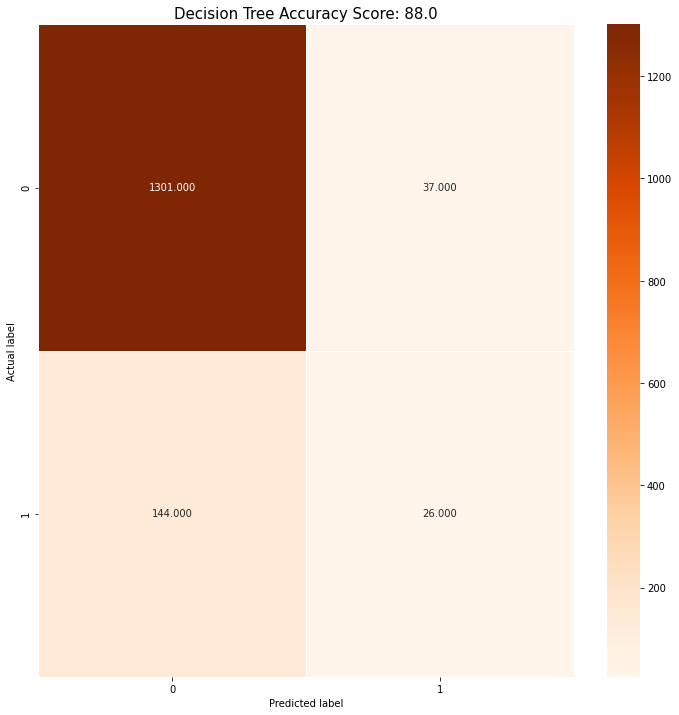

In [68]:
# plot confusion matrix
plt.figure(figsize=(12,12))
sns.heatmap(tree_cm, annot=True, cmap='Oranges', fmt='.3f', linewidths=1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
title = 'Decision Tree Accuracy Score: {0}'.format(round(accuracy,2))
plt.title(title, size=15)